# <center> Introduction and Discovery of Natural Language Processing  </center>
<center><strong> Application : Chatbot for answering patient’s simple questions</strong></center>

## Part I
#### Loading libraries, modules

In [2]:
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD
import random
import nltk
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
import json
import pickle
import pandas as pd
import numpy as np
nltk.download('punkt', quiet = True)
nltk.download('wordnet', quiet = True)
nltk.download('stopwords', quiet = True, halt_on_error=False)
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.callbacks import  EarlyStopping
plt.style.use('grayscale')

In [3]:
intents = pd.read_json('intents_dataset.json')

In [4]:
intents.head()

,intents
0,"{'tag': 'greeting', 'patterns': ['Hi there', '..."
1,"{'tag': 'goodbye', 'patterns': ['Bye', 'See yo..."
2,"{'tag': 'thanks', 'patterns': ['Thanks', 'Than..."
3,"{'tag': 'noanswer', 'patterns': ['', '??'], 'r..."
4,"{'tag': 'options', 'patterns': ['How you could..."


## Part II : Data Processing

### Tokenization

In [5]:
words = []
classes = []
documents = []
ignore_letters = ['!', '?', ',', '.']

for intent in intents['intents']:
    for pattern in intent['patterns']:
        
        word = nltk.word_tokenize(pattern) #tokenize each word
        words.extend(word)
        
        documents.append((word, intent['tag'])) #add documents in the corpus
        
        if intent['tag'] not in classes:
            classes.append(intent['tag']) # add to our classes list

In [6]:
len(words)

281

### Remove Stopwords

#### This help reducing the vocabulary at lest to the required one. Therefore, the training fram time will be impacted positively.

In [7]:
stop_words = set(stopwords.words('english')) 
len(words)     # The vocabulary length before removing stop words

281

In [8]:
filtered_words = [] 
for w in words: 
    if w.lower() not in stop_words: 
        filtered_words.append(w) 
words = filtered_words
len(words)           # The vocabulary length after removing stop words

189

#### lemmatization and lower each word and remove duplicates ( BofW)

In [9]:
words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_letters]
words = sorted(list(set(words)))

classes = sorted(list(set(classes)))
# documents = combination between patterns and intents

print (len(documents), "documents")

# classes = intents

print (len(classes), "classes", classes)
# words = all words, vocabulary

print (len(words), "unique lemmatized words", words)

pickle.dump(words,open('words.pkl','wb'))

pickle.dump(classes,open('classes.pkl','wb'))

78 documents
14 classes ['about', 'adverse_drug', 'blood_pressure', 'blood_pressure_search', 'goodbye', 'greeting', 'help', 'hospital_search', 'name', 'noanswer', 'options', 'pharmacy_search', 'search_pharmacy_by_name', 'thanks']
93 unique lemmatized words ["'s", 'adverse', 'aid', 'anyone', 'awesome', 'behavior', 'blood', 'bye', 'call', 'causing', 'center', 'chatting', 'check', 'community', 'costco', 'could', 'creek', 'cv', 'data', 'day', 'detail', 'drug', 'entry', 'farmacia', 'find', 'give', 'good', 'goodbye', 'hand', 'health', 'hello', 'help', 'helpful', 'helping', 'hey', 'hi', 'history', 'hola', 'hospital', 'id', 'kaiser', 'later', 'list', 'load', 'locate', 'log', 'looking', 'lookup', 'management', 'medical', 'module', 'mowry', "n't", 'name', 'nearby', 'need', 'next', 'nice', 'offered', 'omnicare', 'open', 'patient', 'pharmacy', 'plaza', 'please', 'pressure', 'provide', 'reaction', 'related', 'remedios', 'result', 'rite', 'safeway', 'search', 'searching', 'see', 'show', 'suitable', 

In [10]:
len(words)

93

## Part III : Training and Testing Data

In [11]:
# create the training data
training = list()
trainings = []
# create empty array for the output

output_empty = [0] * len(classes)
# training set, bag of words for every sentence
for doc in documents:
    # initializing bag of words
    bag = []
    # list of tokenized words for the pattern
    word_patterns = doc[0]
    
    # lemmatize each word - create base word, in attempt to represent related words
    word_patterns = [lemmatizer.lemmatize(word.lower()) for word in word_patterns]
    
    # create the bag of words array with 1, if word is found in current pattern
    for word in words:
        bag.append(1) if word in word_patterns else bag.append(0)
        # output is a '0' for each tag and '1' for current tag (for each pattern)
        output_row = list(output_empty)
        output_row[classes.index(doc[1])] = 1
        trainings.append([bag, output_row])
        # shuffle the features and make numpy array
        random.shuffle(trainings)
        training = np.array(trainings)
        # create training and testing lists. X - patterns, Y - intents
        
        train_x = list(training[:,0])
        train_y = list(training[:,1])
print("Training data is created")

<ipython-input-11-818e25a701b0>:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  training = np.array(trainings)


Training data is created


## Part IV :  Training the Model

In [13]:
# deep neural networds model
model = Sequential()
model.add(Dense(128, input_shape=(len(train_x[0]),), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(train_y[0]), activation='softmax'))
# Compiling model. SGD with Nesterov accelerated gradient gives good results for this model
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [14]:
""" Training and saving the model """
hist = model.fit(np.array(train_x), np.array(train_y),
                validation_split=0.33,
                epochs=200, batch_size=5, verbose=1
                )
model.save('chatbot_model.h5', hist)
print("model is created")

Epoch 1/200
972/972 [==============================] - 4s 3ms/step - loss: 1.6411 - accuracy: 0.4839 - val_loss: 0.2263 - val_accuracy: 0.9244
Epoch 2/200
972/972 [==============================] - 2s 2ms/step - loss: 0.3497 - accuracy: 0.8807 - val_loss: 0.1914 - val_accuracy: 0.9265
Epoch 3/200
972/972 [==============================] - 2s 2ms/step - loss: 0.2656 - accuracy: 0.9052 - val_loss: 0.1778 - val_accuracy: 0.9265
Epoch 4/200
972/972 [==============================] - 3s 3ms/step - loss: 0.2366 - accuracy: 0.9105 - val_loss: 0.1760 - val_accuracy: 0.9244
Epoch 5/200
972/972 [==============================] - 3s 3ms/step - loss: 0.2204 - accuracy: 0.9112 - val_loss: 0.1749 - val_accuracy: 0.9244
Epoch 6/200
972/972 [==============================] - 3s 3ms/step - loss: 0.2134 - accuracy: 0.9134 - val_loss: 0.1722 - val_accuracy: 0.9244
Epoch 7/200
972/972 [==============================] - 2s 3ms/step - loss: 0.2029 - accuracy: 0.9172 - val_loss: 0.1751 - val_accuracy: 0.9244

Epoch 58/200
972/972 [==============================] - 2s 2ms/step - loss: 0.1919 - accuracy: 0.9133 - val_loss: 0.1733 - val_accuracy: 0.9244
Epoch 59/200
972/972 [==============================] - 2s 2ms/step - loss: 0.1944 - accuracy: 0.9101 - val_loss: 0.1696 - val_accuracy: 0.9265
Epoch 60/200
972/972 [==============================] - 2s 2ms/step - loss: 0.1756 - accuracy: 0.9213 - val_loss: 0.1718 - val_accuracy: 0.9244
Epoch 61/200
972/972 [==============================] - 2s 2ms/step - loss: 0.1680 - accuracy: 0.9223 - val_loss: 0.1693 - val_accuracy: 0.9265
Epoch 62/200
972/972 [==============================] - 2s 2ms/step - loss: 0.1838 - accuracy: 0.9186 - val_loss: 0.1700 - val_accuracy: 0.9265
Epoch 63/200
972/972 [==============================] - 2s 2ms/step - loss: 0.1889 - accuracy: 0.9158 - val_loss: 0.1715 - val_accuracy: 0.9244
Epoch 64/200
972/972 [==============================] - 2s 2ms/step - loss: 0.1780 - accuracy: 0.9171 - val_loss: 0.1706 - val_accuracy:

Epoch 115/200
972/972 [==============================] - 2s 2ms/step - loss: 0.1685 - accuracy: 0.9259 - val_loss: 0.1713 - val_accuracy: 0.9265
Epoch 116/200
972/972 [==============================] - 2s 2ms/step - loss: 0.1811 - accuracy: 0.9193 - val_loss: 0.1708 - val_accuracy: 0.9244
Epoch 117/200
972/972 [==============================] - 2s 2ms/step - loss: 0.1817 - accuracy: 0.9148 - val_loss: 0.1702 - val_accuracy: 0.9265
Epoch 118/200
972/972 [==============================] - 2s 2ms/step - loss: 0.1764 - accuracy: 0.9225 - val_loss: 0.1702 - val_accuracy: 0.9244
Epoch 119/200
972/972 [==============================] - 2s 2ms/step - loss: 0.1709 - accuracy: 0.9228 - val_loss: 0.1712 - val_accuracy: 0.9244
Epoch 120/200
972/972 [==============================] - 2s 2ms/step - loss: 0.1827 - accuracy: 0.9230 - val_loss: 0.1709 - val_accuracy: 0.9244
Epoch 121/200
972/972 [==============================] - 2s 2ms/step - loss: 0.1653 - accuracy: 0.9258 - val_loss: 0.1699 - val_ac

972/972 [==============================] - 2s 2ms/step - loss: 0.1695 - accuracy: 0.9248 - val_loss: 0.1713 - val_accuracy: 0.9244
Epoch 172/200
972/972 [==============================] - 2s 2ms/step - loss: 0.1723 - accuracy: 0.9252 - val_loss: 0.1699 - val_accuracy: 0.9265
Epoch 173/200
972/972 [==============================] - 2s 2ms/step - loss: 0.1825 - accuracy: 0.9174 - val_loss: 0.1695 - val_accuracy: 0.9265
Epoch 174/200
972/972 [==============================] - 2s 2ms/step - loss: 0.1713 - accuracy: 0.9255 - val_loss: 0.1705 - val_accuracy: 0.9244
Epoch 175/200
972/972 [==============================] - 2s 2ms/step - loss: 0.1718 - accuracy: 0.9202 - val_loss: 0.1690 - val_accuracy: 0.9265
Epoch 176/200
972/972 [==============================] - 2s 2ms/step - loss: 0.1736 - accuracy: 0.9210 - val_loss: 0.1702 - val_accuracy: 0.9244
Epoch 177/200
972/972 [==============================] - 2s 2ms/step - loss: 0.1871 - accuracy: 0.9157 - val_loss: 0.1711 - val_accuracy: 0.9244

### Model Assessment

#### Use of Automatic Verification Datasets


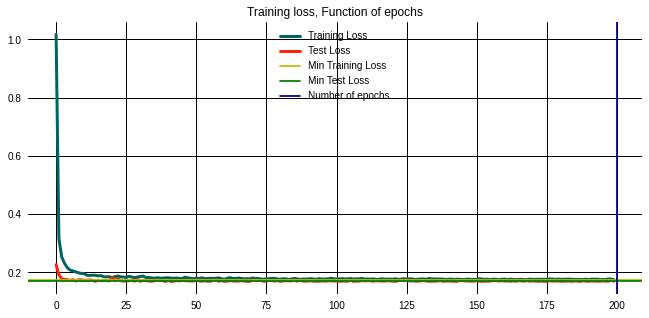

In [18]:
plt.figure(figsize=(11, 5))
plt.style.use('grayscale')

plt.plot(hist.history['loss'], '-', c='#006464', label='Training Loss', linewidth=3)
plt.plot(hist.history['val_loss'], '-', c='#FF2309', label='Test Loss', linewidth=3)
plt.axhline(np.min(hist.history['loss']), color='y', label='Min Training Loss')
plt.axhline(np.min(hist.history['val_loss']), color='g', label='Min Test Loss')
plt.axvline(200, color='#000080', label='Number of epochs')

plt.title('Training loss, Function of epochs')
plt.legend()
plt.savefig('imageloss.png')
plt.show()

In both use of Automatic Verification Datasets and  Use of Manual Verification Datasets evaluation, the training and validation (test) loss keep the same value in the range of 3 and 200 epochs. So, can we reduce the number of epochs and improve training frame time.

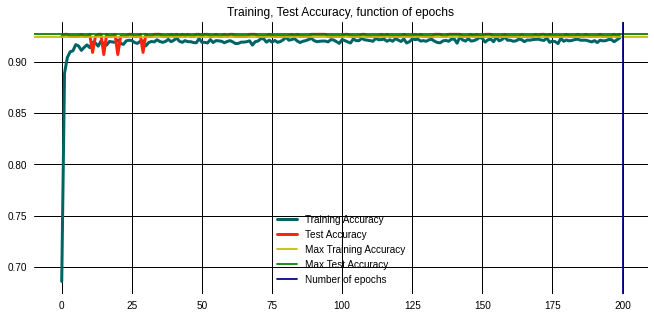

In [22]:
plt.figure(figsize=(11, 5))
plt.style.use('grayscale')

plt.plot(hist.history['accuracy'], '-', c='#006464', label='Training Accuracy', linewidth=3)
plt.plot(hist.history['val_accuracy'], '-', c='#FF2309', label='Test Accuracy', linewidth=3)

plt.axhline(np.max(hist.history['accuracy']), color='y', label='Max Training Accuracy')
plt.axhline(np.max(hist.history['val_accuracy']), color='g', label='Max Test Accuracy')
plt.axvline(200, color='#000080', label='Number of epochs')

plt.title('Training, Test Accuracy, function of epochs')
plt.savefig('imageaccuracy.png')
plt.legend()
plt.show()

#### In both use of Automatic Verification Datasets and  Use of Manual Verification Datasets evaluation, the training and validation (test) accuracy keep the same value in the range of 3 and 200 epochs. So, can we reduce the number of epochs and improve training frame time.

#### Use Manual Verification Datasets

In [23]:
from sklearn.model_selection import train_test_split

seed = 7
np.random.seed(seed)
X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.33, random_state=seed)
# create model

In [24]:
hist = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200, batch_size=70)

Epoch 1/200
70/70 [==============================] - 1s 16ms/step - loss: 0.1740 - accuracy: 0.9216 - val_loss: 0.1729 - val_accuracy: 0.9261
Epoch 2/200
70/70 [==============================] - 0s 5ms/step - loss: 0.1747 - accuracy: 0.9206 - val_loss: 0.1730 - val_accuracy: 0.9261
Epoch 3/200
70/70 [==============================] - 0s 5ms/step - loss: 0.1717 - accuracy: 0.9239 - val_loss: 0.1731 - val_accuracy: 0.9215
Epoch 4/200
70/70 [==============================] - 0s 5ms/step - loss: 0.1740 - accuracy: 0.9212 - val_loss: 0.1730 - val_accuracy: 0.9215
Epoch 5/200
70/70 [==============================] - 0s 5ms/step - loss: 0.1724 - accuracy: 0.9224 - val_loss: 0.1732 - val_accuracy: 0.9215
Epoch 6/200
70/70 [==============================] - 0s 5ms/step - loss: 0.1736 - accuracy: 0.9210 - val_loss: 0.1731 - val_accuracy: 0.9215
Epoch 7/200
70/70 [==============================] - 0s 5ms/step - loss: 0.1737 - accuracy: 0.9237 - val_loss: 0.1732 - val_accuracy: 0.9215
Epoch 8/200


Epoch 59/200
70/70 [==============================] - 0s 5ms/step - loss: 0.1718 - accuracy: 0.9237 - val_loss: 0.1738 - val_accuracy: 0.9215
Epoch 60/200
70/70 [==============================] - 0s 5ms/step - loss: 0.1713 - accuracy: 0.9233 - val_loss: 0.1736 - val_accuracy: 0.9215
Epoch 61/200
70/70 [==============================] - 0s 5ms/step - loss: 0.1716 - accuracy: 0.9235 - val_loss: 0.1737 - val_accuracy: 0.9215
Epoch 62/200
70/70 [==============================] - 0s 5ms/step - loss: 0.1716 - accuracy: 0.9216 - val_loss: 0.1737 - val_accuracy: 0.9215
Epoch 63/200
70/70 [==============================] - 0s 5ms/step - loss: 0.1715 - accuracy: 0.9222 - val_loss: 0.1736 - val_accuracy: 0.9215
Epoch 64/200
70/70 [==============================] - 0s 5ms/step - loss: 0.1715 - accuracy: 0.9222 - val_loss: 0.1734 - val_accuracy: 0.9215
Epoch 65/200
70/70 [==============================] - 0s 5ms/step - loss: 0.1707 - accuracy: 0.9233 - val_loss: 0.1736 - val_accuracy: 0.9215
Epoch 

70/70 [==============================] - 0s 5ms/step - loss: 0.1721 - accuracy: 0.9220 - val_loss: 0.1739 - val_accuracy: 0.9215
Epoch 117/200
70/70 [==============================] - 0s 5ms/step - loss: 0.1719 - accuracy: 0.9224 - val_loss: 0.1738 - val_accuracy: 0.9215
Epoch 118/200
70/70 [==============================] - 0s 5ms/step - loss: 0.1707 - accuracy: 0.9235 - val_loss: 0.1737 - val_accuracy: 0.9215
Epoch 119/200
70/70 [==============================] - 0s 5ms/step - loss: 0.1709 - accuracy: 0.9237 - val_loss: 0.1735 - val_accuracy: 0.9215
Epoch 120/200
70/70 [==============================] - 0s 5ms/step - loss: 0.1719 - accuracy: 0.9226 - val_loss: 0.1734 - val_accuracy: 0.9215
Epoch 121/200
70/70 [==============================] - 0s 5ms/step - loss: 0.1721 - accuracy: 0.9235 - val_loss: 0.1736 - val_accuracy: 0.9215
Epoch 122/200
70/70 [==============================] - 0s 5ms/step - loss: 0.1711 - accuracy: 0.9247 - val_loss: 0.1736 - val_accuracy: 0.9215
Epoch 123/200

70/70 [==============================] - 0s 5ms/step - loss: 0.1711 - accuracy: 0.9243 - val_loss: 0.1735 - val_accuracy: 0.9215
Epoch 174/200
70/70 [==============================] - 0s 5ms/step - loss: 0.1709 - accuracy: 0.9247 - val_loss: 0.1737 - val_accuracy: 0.9215
Epoch 175/200
70/70 [==============================] - 0s 5ms/step - loss: 0.1719 - accuracy: 0.9226 - val_loss: 0.1736 - val_accuracy: 0.9215
Epoch 176/200
70/70 [==============================] - 0s 5ms/step - loss: 0.1722 - accuracy: 0.9237 - val_loss: 0.1736 - val_accuracy: 0.9215
Epoch 177/200
70/70 [==============================] - 0s 5ms/step - loss: 0.1728 - accuracy: 0.9237 - val_loss: 0.1736 - val_accuracy: 0.9215
Epoch 178/200
70/70 [==============================] - 0s 5ms/step - loss: 0.1723 - accuracy: 0.9239 - val_loss: 0.1734 - val_accuracy: 0.9215
Epoch 179/200
70/70 [==============================] - 0s 5ms/step - loss: 0.1715 - accuracy: 0.9241 - val_loss: 0.1734 - val_accuracy: 0.9215
Epoch 180/200

#### Use Manual Verification Datasets

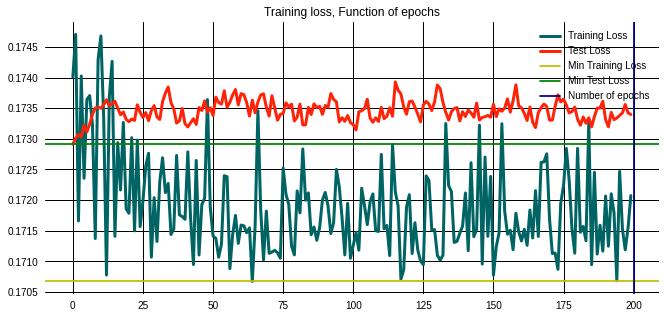

In [31]:
plt.figure(figsize=(11, 5))
plt.style.use('grayscale')

plt.plot(hist.history['loss'], '-', c='#006464', label='Training Loss', linewidth=3)
plt.plot(hist.history['val_loss'], '-', c='#FF2309', label='Test Loss', linewidth=3)
plt.axhline(np.min(hist.history['loss']), color='y', label='Min Training Loss')
plt.axhline(np.min(hist.history['val_loss']), color='g', label='Min Test Loss')
plt.axvline(200, color='#000080', label='Number of epochs')

plt.title('Training loss, Function of epochs')
plt.legend()
plt.savefig('imageloss.png')
plt.show()

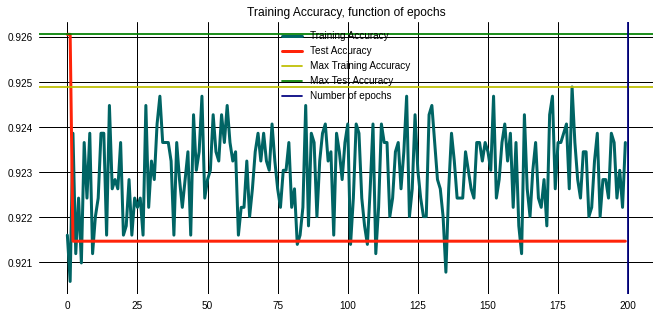

In [34]:
plt.figure(figsize=(11, 5))
plt.style.use('grayscale')
plt.plot(hist.history['accuracy'], '-', c='#006464', label='Training Accuracy', linewidth=3)
plt.plot(hist.history['val_accuracy'], '-', c='#FF2309', label='Test Accuracy', linewidth=3)

plt.axhline(np.max(hist.history['accuracy']), color='y', label='Max Training Accuracy')
plt.axhline(np.max(hist.history['val_accuracy']), color='g', label='Max Test Accuracy')
plt.axvline(200, color='#000080', label='Number of epochs')

plt.title('Training Accuracy, function of epochs')
plt.savefig('imageaccuracy.png')
plt.legend()
plt.show()

### Choosing the number of Epochs

In [35]:
# Maximize the validation by choosing the number of epochs
custom_callback = [EarlyStopping(
    monitor='val_accuracy', mode='max', patience=7
)]

### Use of Automatic validation datasets

In [36]:
""" Choosing the number of epochs """
hist = model.fit(np.array(train_x), np.array(train_y),
                validation_split=0.30,
                epochs=200, batch_size=10, verbose=1,
                callbacks=custom_callback
                )
model.save('chatbot_model.h5', hist)
print("model is created")

Epoch 1/200
508/508 [==============================] - 2s 3ms/step - loss: 0.1757 - accuracy: 0.9218 - val_loss: 0.1683 - val_accuracy: 0.9270
Epoch 2/200
508/508 [==============================] - 2s 3ms/step - loss: 0.1751 - accuracy: 0.9218 - val_loss: 0.1695 - val_accuracy: 0.9256
Epoch 3/200
508/508 [==============================] - 2s 3ms/step - loss: 0.1749 - accuracy: 0.9214 - val_loss: 0.1694 - val_accuracy: 0.9256
Epoch 4/200
508/508 [==============================] - 2s 3ms/step - loss: 0.1744 - accuracy: 0.9232 - val_loss: 0.1689 - val_accuracy: 0.9256
Epoch 5/200
508/508 [==============================] - 2s 3ms/step - loss: 0.1758 - accuracy: 0.9198 - val_loss: 0.1684 - val_accuracy: 0.9270
Epoch 6/200
508/508 [==============================] - 2s 3ms/step - loss: 0.1743 - accuracy: 0.9214 - val_loss: 0.1686 - val_accuracy: 0.9270
Epoch 7/200
508/508 [==============================] - 2s 3ms/step - loss: 0.1733 - accuracy: 0.9242 - val_loss: 0.1685 - val_accuracy: 0.9270

In [37]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test loss: {test_loss},\nTest accuracy: {test_accuracy}")
print(f"""Training loss: {np.mean(hist.history['loss'])},
        \nTraining accuracy: {np.mean(hist.history['accuracy'])}""")

75/75 [==============================] - 0s 2ms/step - loss: 0.1722 - accuracy: 0.9261
Test loss: 0.17219693958759308,
Test accuracy: 0.9260651469230652
Training loss: 0.17488042078912258,
        
Training accuracy: 0.9216564744710922


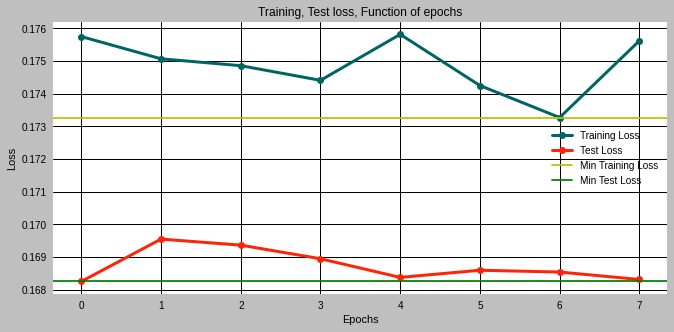

In [45]:
plt.figure(figsize=(11, 5))
plt.style.use('grayscale')

plt.plot(hist.history['loss'], 'o-', c='#006464', label='Training Loss', linewidth=3)
plt.plot(hist.history['val_loss'], 'o-', c='#FF2309', label='Test Loss', linewidth=3)
plt.axhline(np.min(hist.history['loss']), color='y', label='Min Training Loss')
plt.axhline(np.min(hist.history['val_loss']), color='g', label='Min Test Loss')

plt.title('Training, Test loss, Function of epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('imageloss.png')
plt.show()

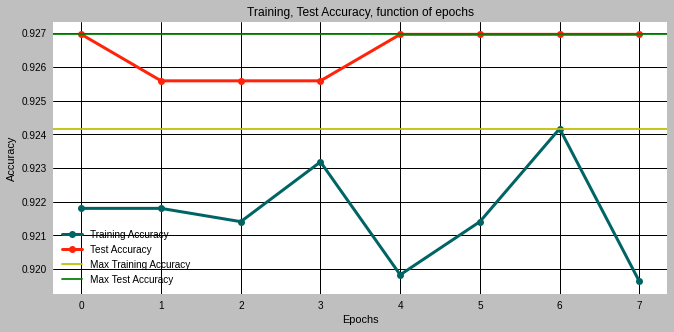

In [48]:
plt.figure(figsize=(11, 5))
plt.style.use('grayscale')
plt.plot(hist.history['accuracy'], 'o-', c='#006464', label='Training Accuracy', linewidth=3)
plt.plot(hist.history['val_accuracy'], 'o-', c='#FF2309', label='Test Accuracy', linewidth=3)

plt.axhline(np.max(hist.history['accuracy']), color='y', label='Max Training Accuracy')
plt.axhline(np.max(hist.history['val_accuracy']), color='g', label='Max Test Accuracy')

plt.title('Training, Test Accuracy, function of epochs')
plt.savefig('imageaccuracy.png')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Use of Manual validation datasets

In [49]:
seed = 7
np.random.seed(seed)
X_train, X_test, y_train, y_test = train_test_split(train_x, train_y,
    test_size=0.30, random_state=seed
    )
    
# Maximize the validation by choosing the number of epochs
custom_callback = [EarlyStopping(
    monitor='val_accuracy', mode='max', patience=7
)]

In [50]:
""" Choosing the number of epochs """
hist = model.fit(np.array(train_x), np.array(train_y),
                validation_data=(X_test, y_test),
                epochs=200, batch_size=10, verbose=1,
                callbacks=custom_callback
                )
model.save('chatbot_model.h5', hist)
print("model is created")

Epoch 1/200
726/726 [==============================] - 3s 4ms/step - loss: 0.1729 - accuracy: 0.9218 - val_loss: 0.1747 - val_accuracy: 0.9256
Epoch 2/200
726/726 [==============================] - 2s 3ms/step - loss: 0.1732 - accuracy: 0.9239 - val_loss: 0.1761 - val_accuracy: 0.9205
Epoch 3/200
726/726 [==============================] - 2s 3ms/step - loss: 0.1736 - accuracy: 0.9218 - val_loss: 0.1748 - val_accuracy: 0.9256
Epoch 4/200
726/726 [==============================] - 2s 3ms/step - loss: 0.1734 - accuracy: 0.9229 - val_loss: 0.1746 - val_accuracy: 0.9256
Epoch 5/200
726/726 [==============================] - 2s 3ms/step - loss: 0.1750 - accuracy: 0.9210 - val_loss: 0.1757 - val_accuracy: 0.9205
Epoch 6/200
726/726 [==============================] - 2s 3ms/step - loss: 0.1731 - accuracy: 0.9221 - val_loss: 0.1753 - val_accuracy: 0.9256
Epoch 7/200
726/726 [==============================] - 2s 3ms/step - loss: 0.1736 - accuracy: 0.9231 - val_loss: 0.1759 - val_accuracy: 0.9205

In [51]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test loss: {test_loss},\nTest accuracy: {test_accuracy}")
print(f"""Training loss: {np.mean(hist.history['loss'])},
        \nTraining accuracy: {np.mean(hist.history['accuracy'])}""")

69/69 [==============================] - 0s 2ms/step - loss: 0.1756 - accuracy: 0.9205
Test loss: 0.17557507753372192,
Test accuracy: 0.9205328226089478
Training loss: 0.1735739279538393,
        
Training accuracy: 0.9221464097499847


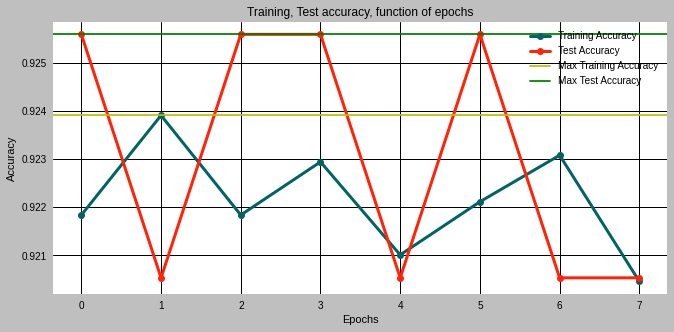

In [52]:
plt.figure(figsize=(11, 5))
plt.style.use('grayscale')
plt.plot(hist.history['accuracy'], 'o-', c='#006464', label='Training Accuracy', linewidth=3)
plt.plot(hist.history['val_accuracy'], 'o-', c='#FF2309', label='Test Accuracy', linewidth=3)

plt.axhline(np.max(hist.history['accuracy']), color='y', label='Max Training Accuracy')
plt.axhline(np.max(hist.history['val_accuracy']), color='g', label='Max Test Accuracy')
#plt.axvline(200, color='#000080', label='Number of epochs')

plt.title('Training, Test accuracy, function of epochs')
plt.savefig('less_epochs/imageaccuracy.png')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

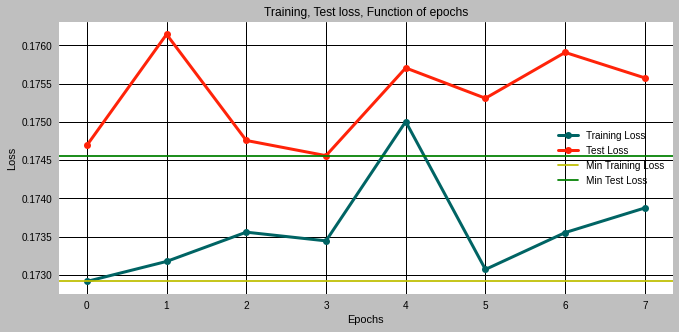

In [53]:
plt.figure(figsize=(11, 5))
plt.style.use('grayscale')

plt.plot(hist.history['loss'], 'o-', c='#006464', label='Training Loss', linewidth=3)
plt.plot(hist.history['val_loss'], 'o-', c='#FF2309', label='Test Loss', linewidth=3)
plt.axhline(np.min(hist.history['loss']), color='y', label='Min Training Loss')
plt.axhline(np.min(hist.history['val_loss']), color='g', label='Min Test Loss')
#plt.axvline(200, color='#000080', label='Number of epochs')

plt.title('Training, Test loss, Function of epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('less_epochs/imageloss.png')
plt.show()

## Part V : Interacting With the Chatbot

In [54]:
import nltk
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
import pickle
import numpy as np
from keras.models import load_model
model = load_model('chatbot_model.h5')
import json
import random
intents = json.loads(open('intents_dataset.json').read())
words = pickle.load(open('words.pkl','rb'))
classes = pickle.load(open('classes.pkl','rb'))

#### Clean up Sentence Function

In [55]:
def clean_up_sentence(sentence):
    # tokenize the pattern - splitting words into array
    sentence_words = nltk.word_tokenize(sentence)
  
    # stemming every word - reducing to base form

    sentence_words = [lemmatizer.lemmatize(word.lower()) for word in sentence_words]
    return sentence_words
    #return bag of words array: 0 or 1 for words that exist in sentence

#### Bag of Words Function

In [56]:
def bag_of_words(sentence, words, show_details=True):
    # tokenizing patterns
    sentence_words = clean_up_sentence(sentence)
    # bag of words - vocabulary matrix
    bag = [0]*len(words)  
    for s in sentence_words:
        for i,word in enumerate(words):
            if word == s:
                # assign 1 if current word is in the vocabulary position
                bag[i] = 1
            if show_details:
                print ("found in bag: %s" % word)
    return(np.array(bag))

#### Prection function

In [57]:
def predict_class(sentence):
    # filter below  threshold predictions
    p = bag_of_words(sentence, words,show_details=False)

    res = model.predict(np.array([p]))[0]
    ERROR_THRESHOLD = 0.25

    results = [[i,r] for i,r in enumerate(res) if r>ERROR_THRESHOLD]

    # sorting strength probability

    results.sort(key=lambda x: x[1], reverse=True)

    return_list = []

    for r in results:

        return_list.append({"intent": classes[r[0]], "probability": str(r[1])})
    return return_list

#### Getting responses function

In [58]:
def getResponse(ints, intents_json):

    tag = ints[0]['intent']

    list_of_intents = intents_json['intents']

    for i in list_of_intents:

        if(i['tag']== tag):

            result = random.choice(i['responses'])

            break

    return result

#### Launch Chat Function

In [59]:
def chatting():
    print("Welcome to Talk-To-Me (Write 'quit' to leave the program):")
    
    while(True):
        message = input()
        if message == 'quit':
            break
        elif message != '':
            ints = predict_class(message)
            result = getResponse(ints, intents)
            print(result)

In [60]:
chatting()

Welcome to Talk-To-Me (Write 'quit' to leave the program):
Hello
Hi there, how can I help?
quit
